In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from torchvision import datasets, transforms as T
from torch import nn
from torchsummary import summary

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64
# Optimizers Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99
# Training Variables
epochs = 20

In [8]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
trainset = datasets.FashionMNIST(root='./data', train = True, download = True, transform = transform)

In [11]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [12]:
print(len(trainloader))

469


In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [17]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

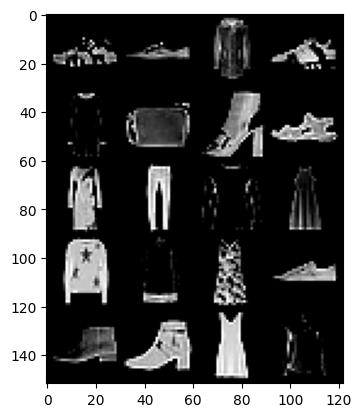

In [15]:
show_tensor_images(images, num_images=20)

In [20]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
      x1 = self.block_1(images)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.flatten(x3)
      x5 = self.linear(x4)
      return x5

In [22]:
D = Discriminator()
D.to(device)
summary(D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [24]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [25]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, noise):

    x = noise.view(-1, noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [26]:
G = Generator()
G.to(device)
summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [29]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [30]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [31]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [32]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 1, Discriminator_Loss = 0.6710563504111284, Generator_Loss = 0.7123256426121889


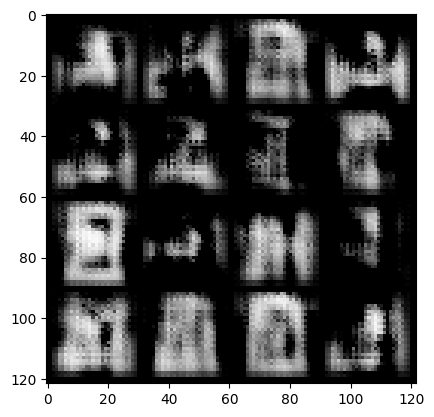

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 2, Discriminator_Loss = 0.6473894173910877, Generator_Loss = 0.7445868866275877


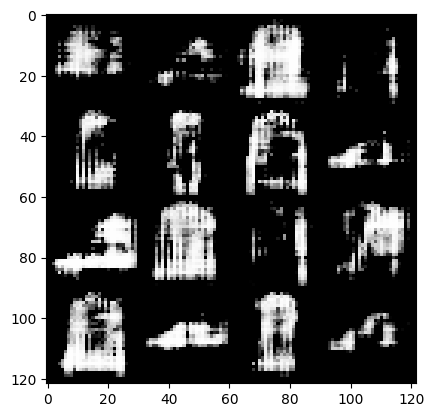

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 3, Discriminator_Loss = 0.64674154540369, Generator_Loss = 0.7606323657513682


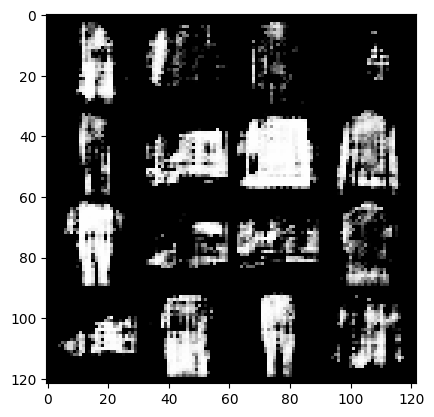

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 4, Discriminator_Loss = 0.640818578220888, Generator_Loss = 0.773165930308767


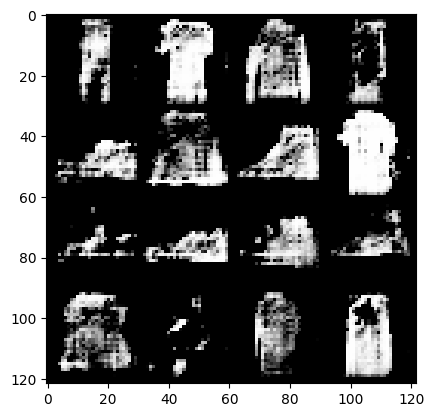

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 5, Discriminator_Loss = 0.6297226703243215, Generator_Loss = 0.7903147868510249


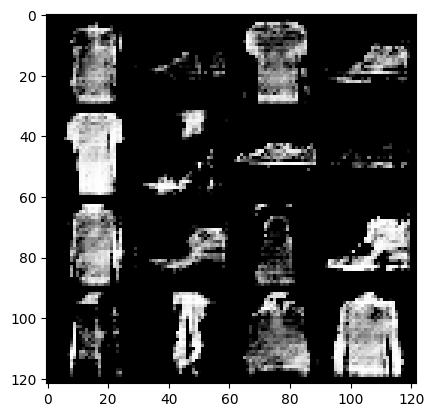

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 6, Discriminator_Loss = 0.6312009923493684, Generator_Loss = 0.7954079440153484


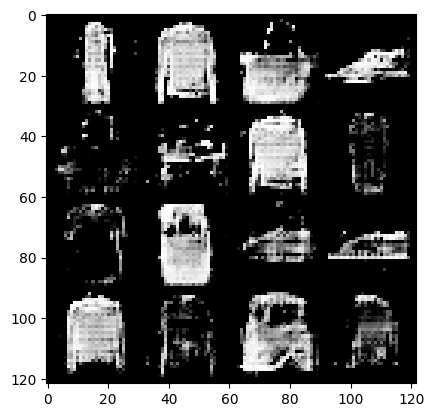

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 7, Discriminator_Loss = 0.634974320433033, Generator_Loss = 0.7973901156677621


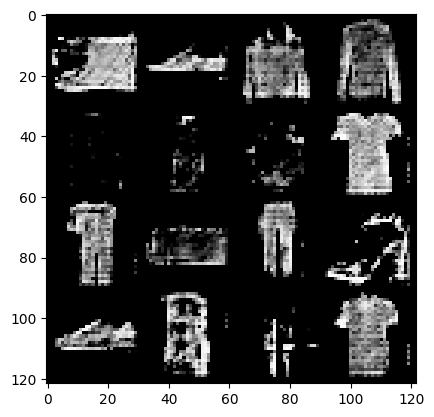

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 8, Discriminator_Loss = 0.6375513168286159, Generator_Loss = 0.79724811389248


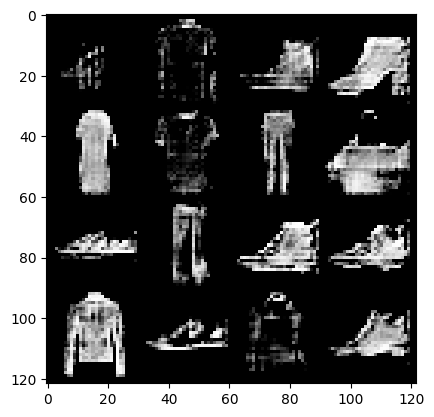

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 9, Discriminator_Loss = 0.6368157863616943, Generator_Loss = 0.8007061013789065


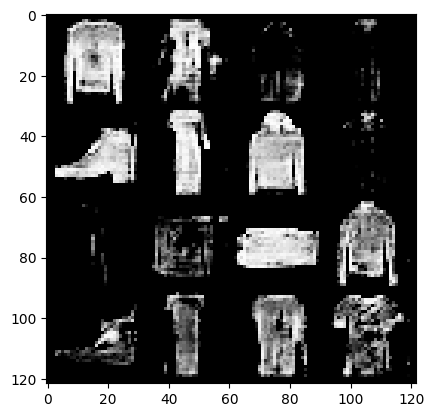

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 10, Discriminator_Loss = 0.6357371427102892, Generator_Loss = 0.8051900007068984


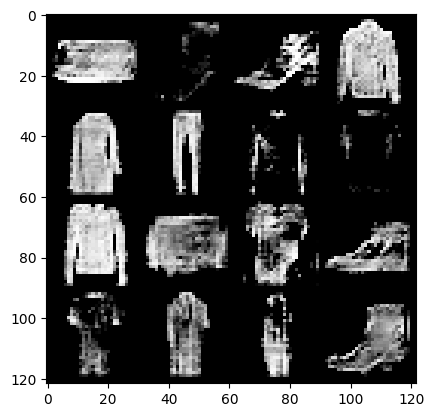

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 11, Discriminator_Loss = 0.6382820284697038, Generator_Loss = 0.8076113800504314


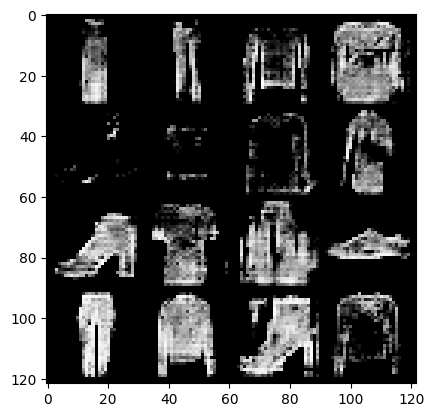

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 12, Discriminator_Loss = 0.6369939212605897, Generator_Loss = 0.8109961565115305


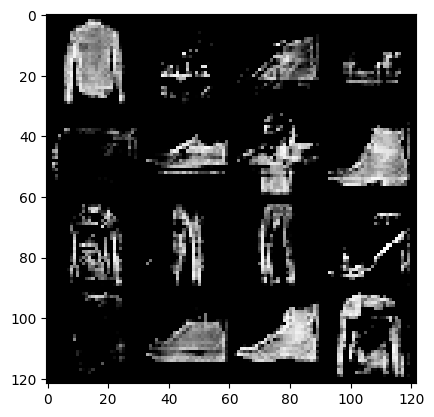

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 13, Discriminator_Loss = 0.6346676464019808, Generator_Loss = 0.8144930815900059


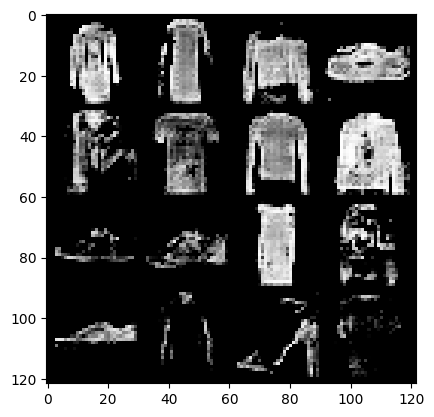

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 14, Discriminator_Loss = 0.6365782908285096, Generator_Loss = 0.8155953276640316


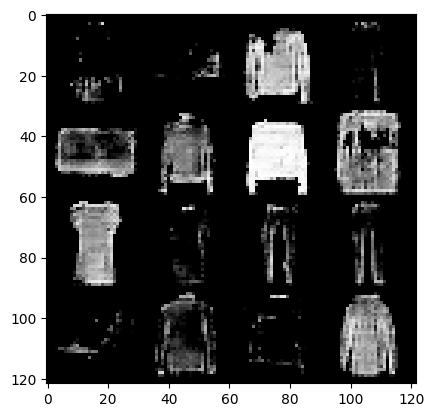

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 15, Discriminator_Loss = 0.6349123957823081, Generator_Loss = 0.8195258746269161


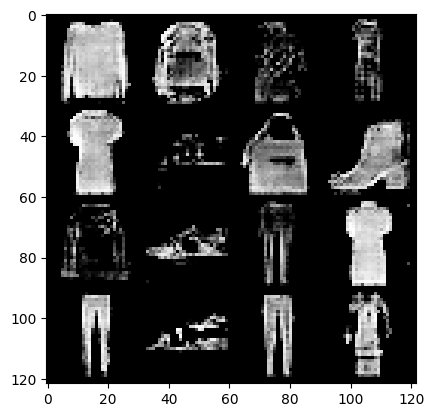

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 16, Discriminator_Loss = 0.6344697152627811, Generator_Loss = 0.8222817744273366


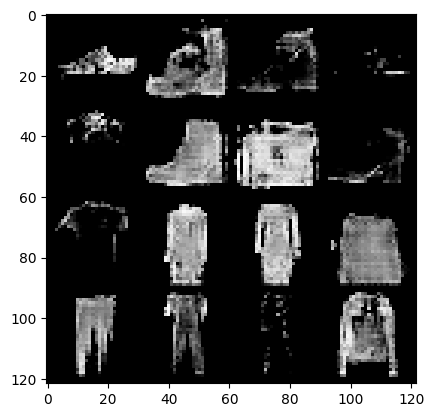

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 17, Discriminator_Loss = 0.6342215475751393, Generator_Loss = 0.8227615051432204


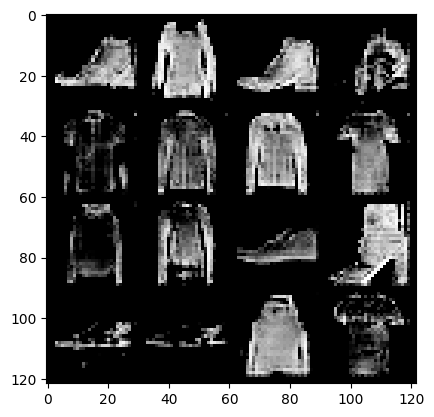

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 18, Discriminator_Loss = 0.6340895696743719, Generator_Loss = 0.8271901681224929


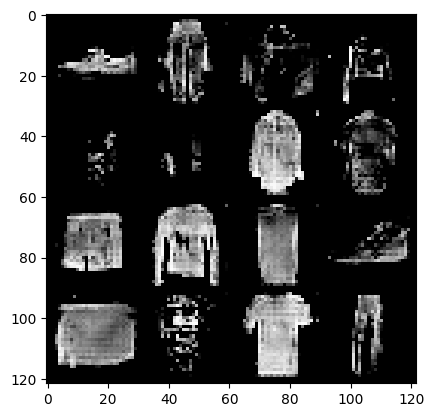

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 19, Discriminator_Loss = 0.632645196243644, Generator_Loss = 0.8312442295078529


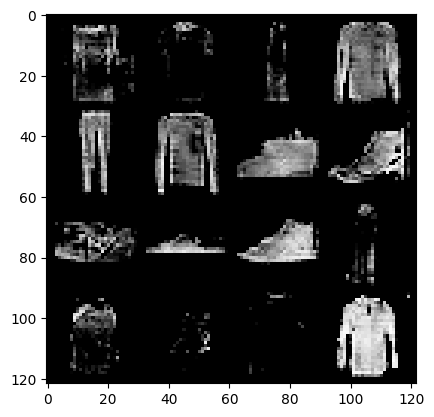

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch = 20, Discriminator_Loss = 0.6326829942304697, Generator_Loss = 0.833965929586496


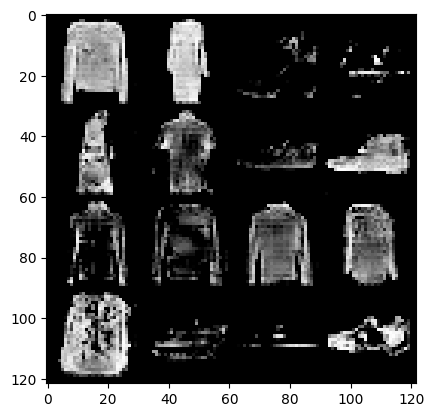

In [33]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_images, _ in tqdm(trainloader):
    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_images = G(noise)
    D_pred = D(fake_images)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_images)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_images = G(noise)
    D_pred = D(fake_images)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch = {}, Discriminator_Loss = {}, Generator_Loss = {}".format(i + 1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_images)

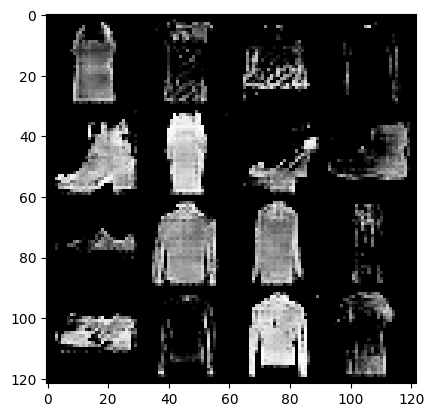

In [34]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)
show_tensor_images(generated_image)